In [1]:
# Importing necessary libraries
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define paths and load data
def define_paths(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)

def split_data(data_dir):
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123)
    return train_df, valid_df, test_df

# Image Data Generator
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    color = 'rgb'
    tr_gen = ImageDataGenerator()
    ts_gen = ImageDataGenerator()

    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                           color_mode=color, batch_size=batch_size)

    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                           color_mode=color, batch_size=batch_size)

    test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                          color_mode=color,  batch_size=batch_size)
    return train_gen, valid_gen, test_gen

# Plot images (optional for visualization)
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    sample = min(len(labels), 25)

    plt.figure(figsize=(20, 20))
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()


In [2]:

# Data path
data_dir = 'D:\Projects\ocular-disease\dataset'

# Load data
train_df, valid_df, test_df = split_data(data_dir)

# Set batch size and generate data generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

# Define the model architecture
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, activation='relu'),
    Dropout(rate=0.45),
    Dense(class_count, activation='softmax')
])

model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    train_gen,
    epochs=40,
    validation_data=valid_gen,
    callbacks=[early_stopping],
    verbose=1
)


<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\AL-MOSTAFA\AppData\Local\Temp\ipykernel_9372\3113242203.py:2: SyntaxWarning: invalid escape sequence '\P'
  data_dir = 'D:\Projects\ocular-disease\dataset'


Found 3782 validated image filenames belonging to 5 classes.
Found 473 validated image filenames belonging to 5 classes.
Found 473 validated image filenames belonging to 5 classes.
Epoch 1/40


g:\Anaconda\envs\env_dlib\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 2794s 21s/step - accuracy: 0.6433 - loss: 1.1546 - val_accuracy: 0.7484 - val_loss: 1.0553
Epoch 2/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 1808s 19s/step - accuracy: 0.9027 - loss: 0.2778 - val_accuracy: 0.8647 - val_loss: 0.4385
Epoch 3/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 1713s 18s/step - accuracy: 0.9157 - loss: 0.2757 - val_accuracy: 0.8922 - val_loss: 0.3277
Epoch 4/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 1162s 12s/step - accuracy: 0.9456 - loss: 0.1485 - val_accuracy: 0.9027 - val_loss: 0.2647
Epoch 5/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 902s 9s/step - accuracy: 0.9636 - loss: 0.0973 - val_accuracy: 0.9281 - val_loss: 0.2339
Epoch 6/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 829s 9s/step - accuracy: 0.9649 - loss: 0.0914 - val_accuracy: 0.9429 - val_loss: 0.1971
Epoch 7/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 799s 8s/step - accuracy: 0.9769 - loss: 0.0734 - val_accuracy: 0.9387 - val_loss: 0.1987
Epoch 8/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 800s 8s/step - accuracy: 0.9780 - loss: 0.0578 - val_accuracy: 0.9493 - val_

In [3]:

# Evaluate the model
test_score = model.evaluate(test_gen, verbose=1)

# Print test results
print(f"Test Loss: {test_score[0]}")
print(f"Test Accuracy: {test_score[1]}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9428 - loss: 0.2356
Test Loss: 0.24436284601688385
Test Accuracy: 0.9471458792686462


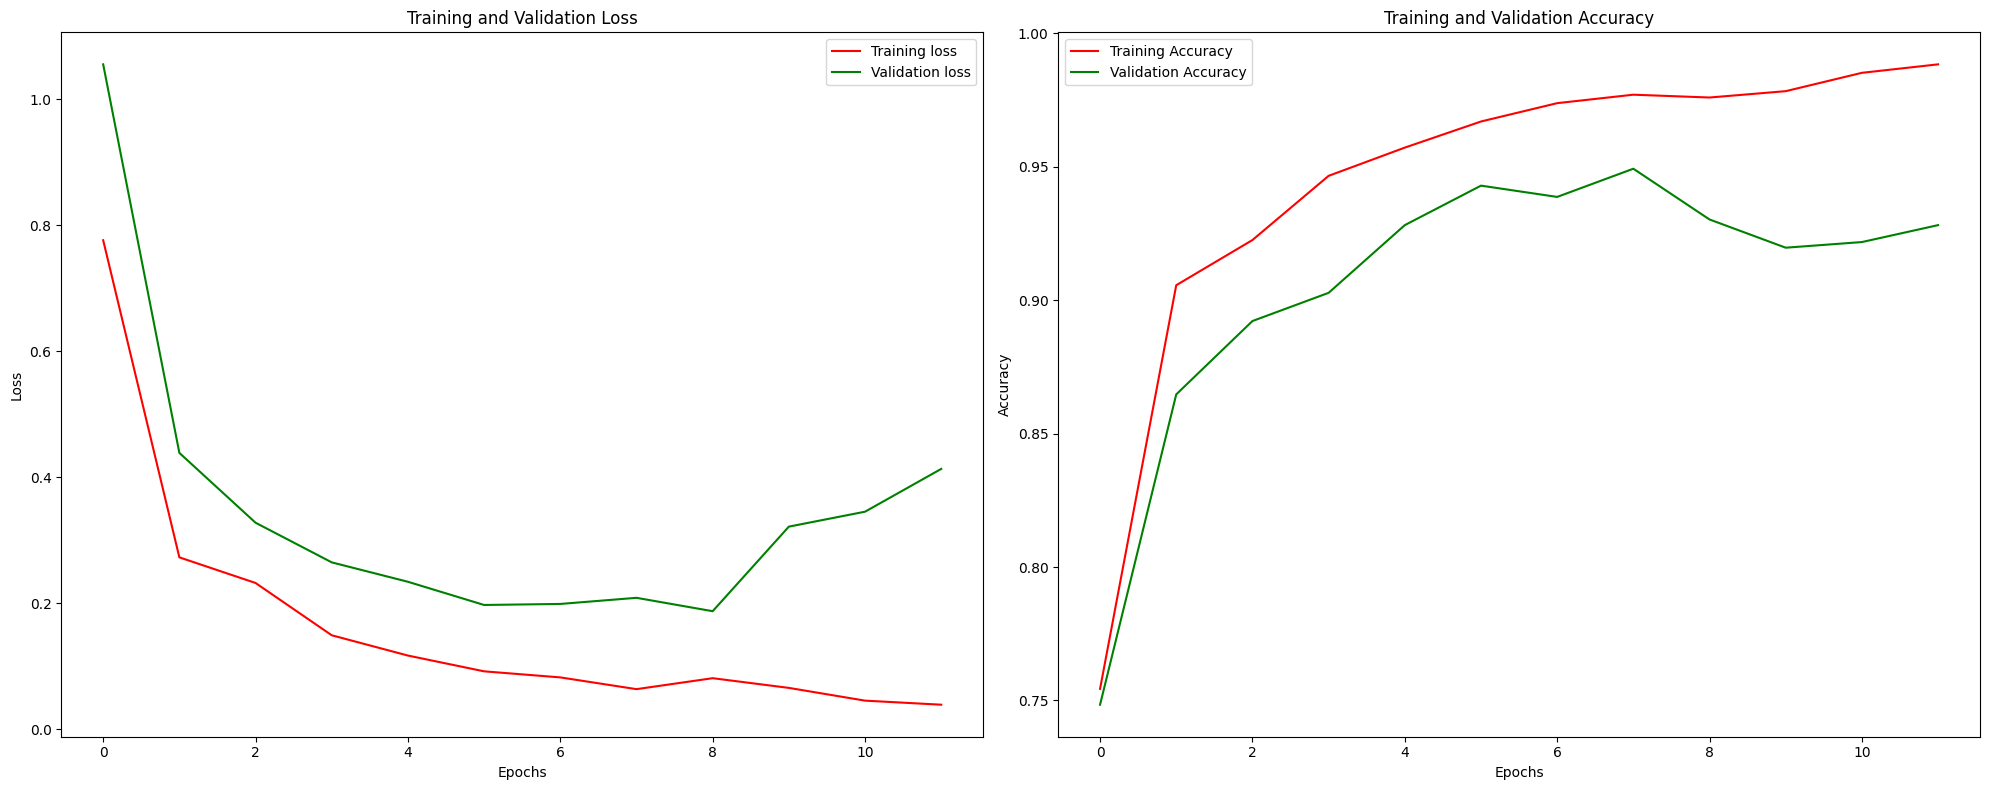

In [4]:

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(20, 8))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'r', label='Training loss')
    plt.plot(history.history['val_loss'], 'g', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], 'r', label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], 'g', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


In [5]:

# Save the model
model_save_path = 'model.h5'
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to model.h5


In [59]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model(model_save_path)


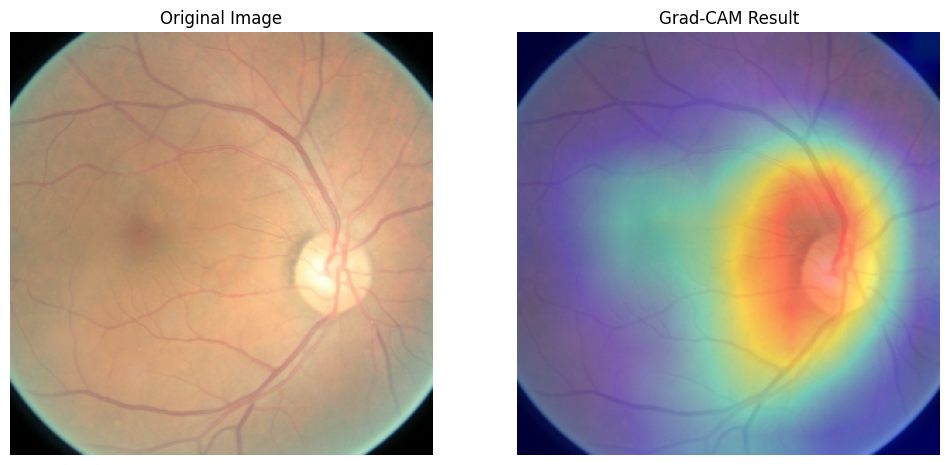

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

# Function to load and preprocess image
def get_img_array(img_path, size=(300, 300)):
    img = image.load_img(img_path, target_size=size)
    img_array = image.img_to_array(img)
    return np.expand_dims(img_array, axis=0)

# Grad-CAM function
def grad_cam(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = np.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))2

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[tf.newaxis]
    heatmap = tf.reduce_sum(heatmap, axis=-1)[tf.newaxis]
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) 

    # Return the heatmap as a numpy array
    return heatmap

# Function to save and display Grad-CAM heatmap
def save_and_display_gradcam(img_path, heatmap, img_size=(300, 300)):
    # Load and resize the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    
    # Resize the heatmap to match the original image
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)

    # Apply the heatmap as color overlay
    heatmap_img = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_img, 0.4, 0)

    # Save the result
    result_path = 'gradcam_result.png'
    cv2.imwrite(result_path, superimposed_img)
    
    # Display the original image and the Grad-CAM result
    plt.figure(figsize=(12, 6))
    
    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    plt.title("Original Image")
    plt.axis('off')
    
    # Display the Grad-CAM result
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    plt.title("Grad-CAM Result")
    plt.axis('off')
    
    plt.show()

# Main function to apply Grad-CAM on EfficientNetB3
def grad_cam_effnetb3(model, img_path, last_conv_layer_name='top_conv', img_size=(300, 300)):
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

    # Get Grad-CAM heatmap
    heatmap = grad_cam(model, img_array, last_conv_layer_name)

    # Save and display the Grad-CAM heatmap
    save_and_display_gradcam(img_path, heatmap)

# Load the EfficientNetB3 model
model = EfficientNetB3(weights="imagenet")

# Path to your image
img_path = 'dataset/diabetic_retinopathy/119_left.jpeg'
# Apply Grad-CAM
grad_cam_effnetb3(model, img_path)
